In [22]:
import uproot
import logging
import numpy as np
import pandas as pd
import click
import matplotlib.pyplot as plt
import os
import scipy.stats as ss

import matplotlib
import matplotlib.colors as colors

from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.image import tailcuts_clean, hillas_parameters, leakage, concentration
from ctapipe.image.timing_parameters import timing_parameters
from ctapipe.image.cleaning import number_of_islands

In [23]:
def read_from_root(filename):
    ARRAY_COLUMNS = {
        'MRawEvtHeader.fStereoEvtNumber': 'stereo_evt_number',
        'MTriggerPattern.fPrescaled': 'triggerpattern'
    }
    PIXEL_COLUMNS = {
        'MArrivalTime.fData': 'photon_time',
        'MCerPhotEvt.fPixels.fPhot': 'phe',
    }

    f = uproot.open(filename)
    print("Starting")
    tree = f['Events']
    ids = np.arange(tree.numentries)

    print("Reading event-wise info")
    df = tree.pandas.df(ARRAY_COLUMNS.keys())
    df.rename(columns=ARRAY_COLUMNS, inplace=True)
    print("Reading ids")

    df['event_id'] = ids
    df = df[df['stereo_evt_number'] > 0]  # Select the events that triggered in both telescopes                                                                                    

    print("Reading pixel-wise info")
    df2 = tree.pandas.df(PIXEL_COLUMNS.keys())  # The dataframe containing the pixel data                                                                                          
    df2.rename(columns=PIXEL_COLUMNS, inplace=True)

    # EVENT START FROM 1                                                                                                                                                           
    event_idx = df['event_id'].values
    print("Finishing")

    return df, df2

In [25]:
df1, df2 = read_from_root(filenameM1)

Starting
Reading event-wise info
Reading ids
Reading pixel-wise info
Finishing


In [26]:
idx = 12194
df1['stereo_evt_number'][idx]
phe1 = np.array(df2['phe'][idx])

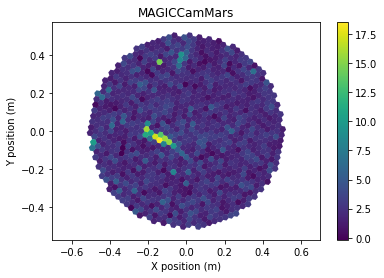

In [27]:
phe = phe1[:1039]

camera_MAGIC = CameraGeometry.from_name('MAGICCamMars')
display = CameraDisplay(camera_MAGIC)
display.image = phe
display.add_colorbar()

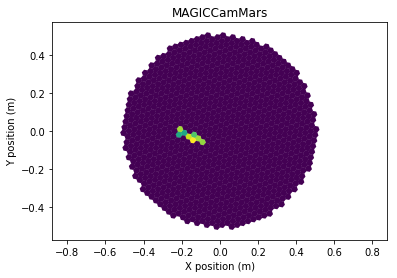

In [28]:
event_image = phe
clean = tailcuts_clean(camera_MAGIC, event_image, picture_thresh=10, boundary_thresh=10)
event_image_cleaned = event_image.copy()
event_image_cleaned[~clean] = 0
disp = CameraDisplay(camera_MAGIC, event_image_cleaned)

{'intensity': 118.34375,
 'kurtosis': 1.854550929687033,
 'length': <Quantity 0.04504019 m>,
 'phi': <Angle -2.95817928 rad>,
 'psi': <Angle -0.43118698 rad>,
 'r': <Quantity 0.15671438 m>,
 'skewness': -0.08863950107552415,
 'width': <Quantity 0.01073422 m>,
 'x': <Quantity -0.15408578 m>,
 'y': <Quantity -0.02858263 m>}


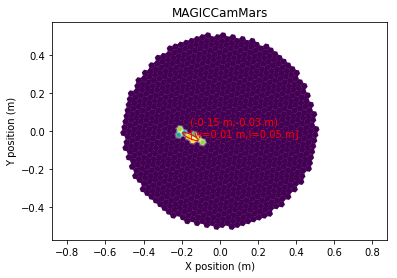

In [29]:
hillas_params = hillas_parameters(camera_MAGIC, event_image_cleaned)
disp = CameraDisplay(camera_MAGIC, event_image_cleaned)
        
# Overlay computed hillas parameters
disp.overlay_moments(hillas_params, color='red', lw=1)
disp.highlight_pixels(clean, color='white', alpha=0.3, linewidth=2)
print(hillas_params)